In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from mlforecast import MLForecast
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [108]:
def evaluate_metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {mae:.3f}")
    print(f"MSE: {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²: {r2:.3f}")

def generate_graphic_prediction(y_test, y_pred, model):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='Valores Reais')
    plt.plot(y_pred.index, y_pred, label='Valores Preditos')
    plt.xlabel('Índice')
    plt.ylabel('Valores')
    plt.title(f'Reais vs Preditos - {model}')
    plt.legend()
    plt.show()

In [74]:
df = pd.read_csv('../data/processed/dados_climaticos_vazao_rio_sao_francisco.csv')
df['data'] = pd.to_datetime(df['data'], errors='coerce')
df.head()

,data,vazao,codigo_bacia,codigo_sub_bacia,umidade_relativa,temp_media,precipitacao,chuva_acum_3d,chuva_acum_5d,chuva_acum_7d,mes,dia,ano,estacao_inverno,estacao_outono,estacao_primavera,estacao_verao
0,1995-01-01,733.0,4.0,40.0,72.13,24.96,1.49,1.49,1.49,1.49,1,1,1995,False,False,False,True
1,1995-01-02,849.0,4.0,40.0,70.76,25.49,5.15,6.64,6.64,6.64,1,2,1995,False,False,False,True
2,1995-01-03,631.0,4.0,40.0,79.37,23.60,8.15,14.79,14.79,14.79,1,3,1995,False,False,False,True
3,1995-01-04,675.0,4.0,40.0,84.65,22.78,20.85,34.15,35.64,35.64,1,4,1995,False,False,False,True
4,1995-01-05,674.0,4.0,40.0,85.12,22.60,5.45,34.45,41.09,41.09,1,5,1995,False,False,False,True


In [95]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)
df_test_x = df_test.drop(columns=['vazao', 'codigo_sub_bacia'])
df_test_y = df_test[['vazao', 'data']]

In [101]:
df_test_y.set_index('data', inplace=True)

In [77]:
lin_reg = LinearRegression() # Regressão linear

dec_tree = DecisionTreeRegressor(random_state = 19) # Árvore de decisão

ran_forest = RandomForestRegressor(random_state = 19, n_estimators = 500) # Random Forest

lgbm = LGBMRegressor(random_state = 19, n_estimators = 500) # LightGBM

xgb = XGBRegressor(random_state = 19, n_estimators = 500) # XGBoost

models_list = [lin_reg, dec_tree, ran_forest, lgbm, xgb]

In [110]:
models_list = [lin_reg, dec_tree, ran_forest, lgbm, xgb]

model = MLForecast(models = models_list, # Lista com 9 modelos
                   freq = 'D', # Frequência diária
                   num_threads = 6,
                   date_features = ['month', 'year', 'quarter', 'day'], # Features de data
           )

model.fit(df_train, id_col='codigo_bacia', time_col='data', target_col='vazao', fitted=True, static_features=['codigo_bacia', 'codigo_sub_bacia'])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 7889, number of used features: 17
[LightGBM] [Info] Start training from score 594.119693


MLForecast(models=[LinearRegression, DecisionTreeRegressor, RandomForestRegressor, LGBMRegressor, XGBRegressor], freq=D, lag_features=[], date_features=['month', 'year', 'quarter', 'day'], num_threads=6)

In [111]:
n_horizon = df_test['data'].nunique()

forecast_prediction = model.predict(h=n_horizon, X_df=df_test_x)

In [112]:
forecast_prediction.set_index('data', inplace=True)

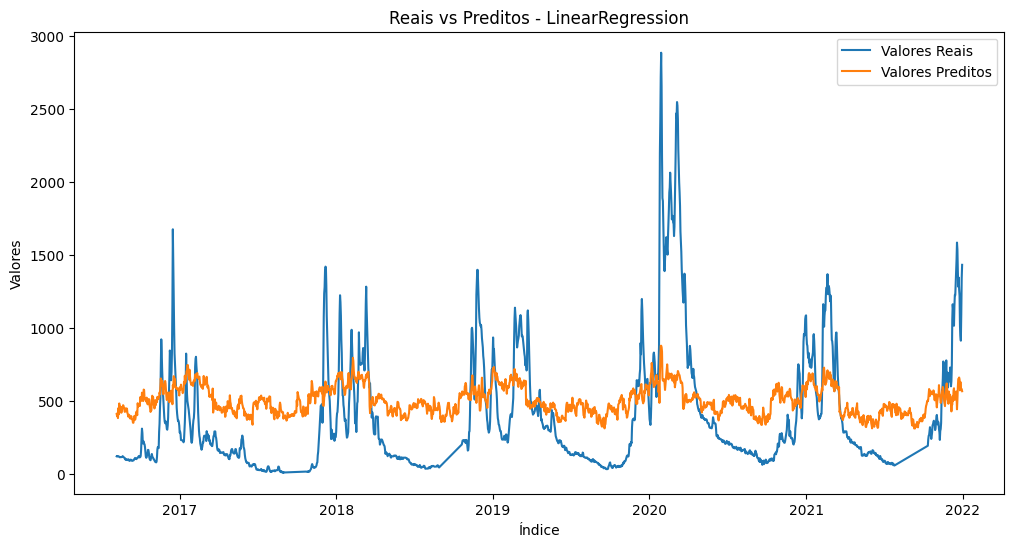

MAE: 313.264
MSE: 144490.609
RMSE: 380.119
R²: 0.131


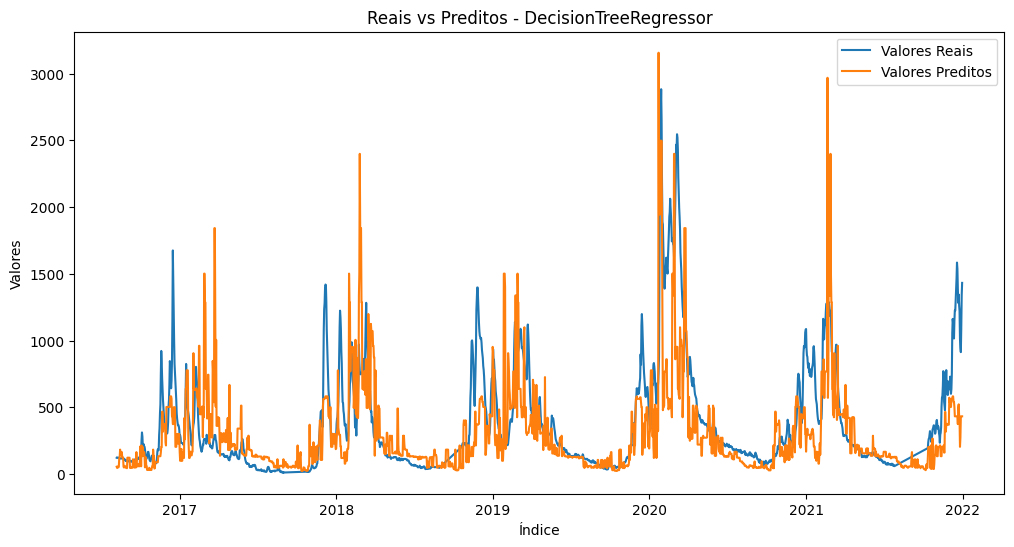

MAE: 192.212
MSE: 107198.383
RMSE: 327.412
R²: 0.355


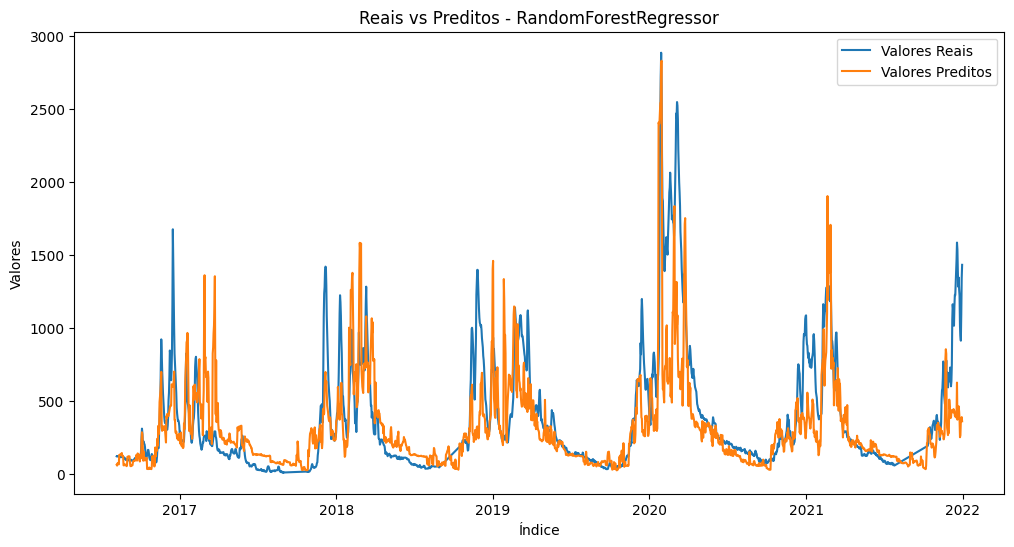

MAE: 164.993
MSE: 83176.527
RMSE: 288.403
R²: 0.500


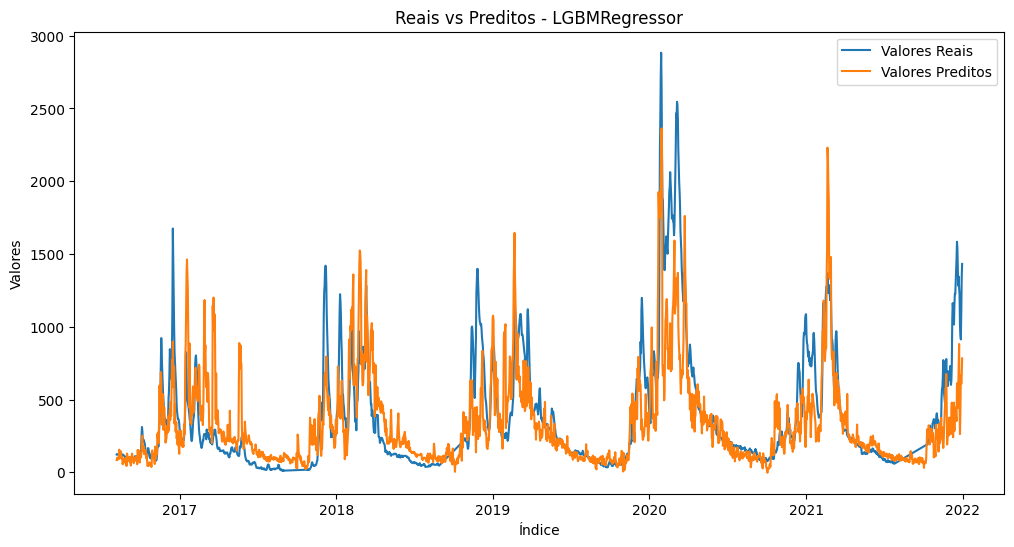

MAE: 164.639
MSE: 76183.320
RMSE: 276.013
R²: 0.542


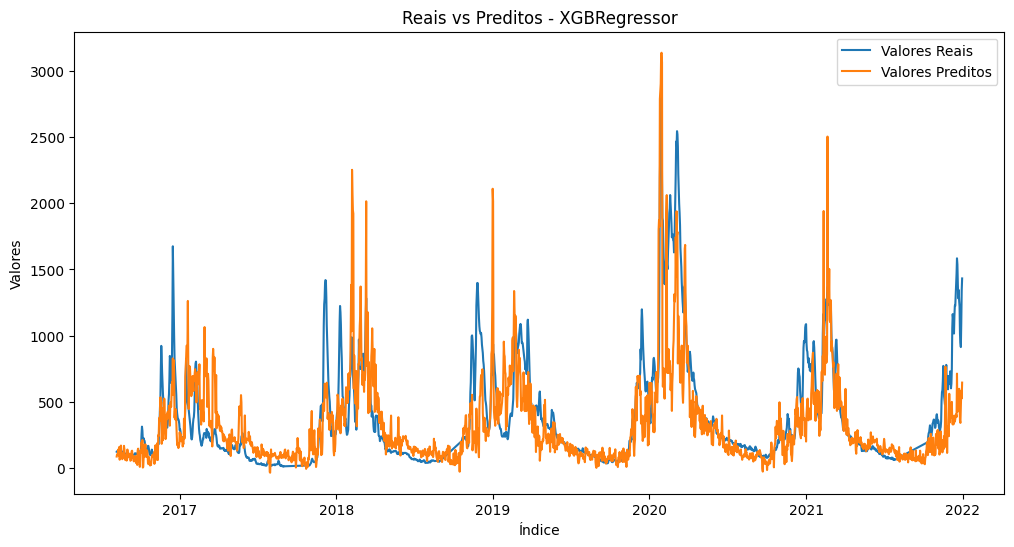

MAE: 169.010
MSE: 80578.445
RMSE: 283.863
R²: 0.516


In [115]:
for model_name in ['LinearRegression', 'DecisionTreeRegressor','RandomForestRegressor', 'LGBMRegressor', 'XGBRegressor']:
    y_pred = forecast_prediction[model_name]
    generate_graphic_prediction(df_test_y, y_pred, model_name)
    evaluate_metrics(df_test_y, y_pred)

Tunning